# ML-13 Project. Part I

Ниже приведено решение первой части проекта по прогнозированию временных рядов. В практике приведены конкретные шаги, которые необходимо выполнить для получения требуемого результата. Эти шаги указаны ниже по пунктам, после каждого пункта идёт код для его реализации.

Также дополнительно приведены собственные исследования и выводы.

**Формулировка задачи:** Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [88]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

## 1. Первоначальная загрузка и анализ данных

Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [89]:
df = pd.read_csv('data/ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
df.rename(columns={'GDP (current US$)':'gdp'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


Text(0.5, 1.0, 'Распределение ВВП африканской страны Гана')

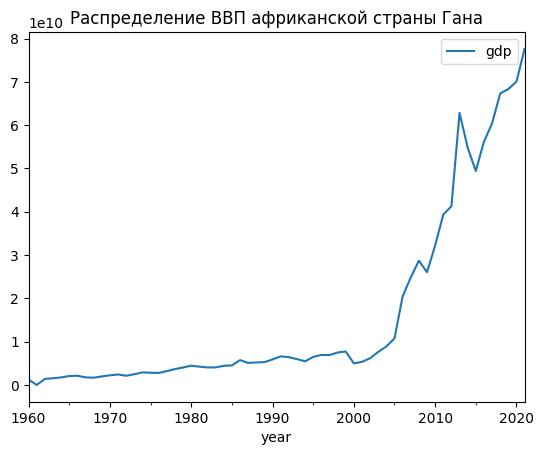

In [90]:
df.plot()
plt.title('Распределение ВВП африканской страны Гана')

**Первичные выводы:** на графике явно прослеживается общий тренд на увеличение. Причём до 2000 года повышение было малозаметным, после чего произошёл резкий скачок, провисший только в середине 10-х, во время мирового кризиса 14-15 года.

Сезонность на первый взгляд не видна.

Разложим ряд на тренд, сезонность и шум:

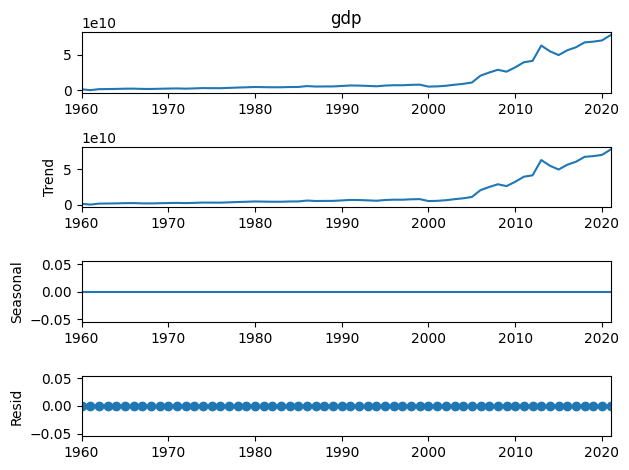

In [91]:
decompos = seasonal_decompose(df.gdp)
decompos.plot()
plt.show()

Как мы видим, наши первоначальные выводы оказались верны: тренд выделен, сезонности нет.

In [92]:
# разделяем выборку на тренировочную и тестовую
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
print(train_df.shape, test_df.shape)

(59, 1) (3, 1)


## 2. Построение модели скользящего среднего – MA

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

**Пример**: `train_df.spx.rolling(window=2).mean()`

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

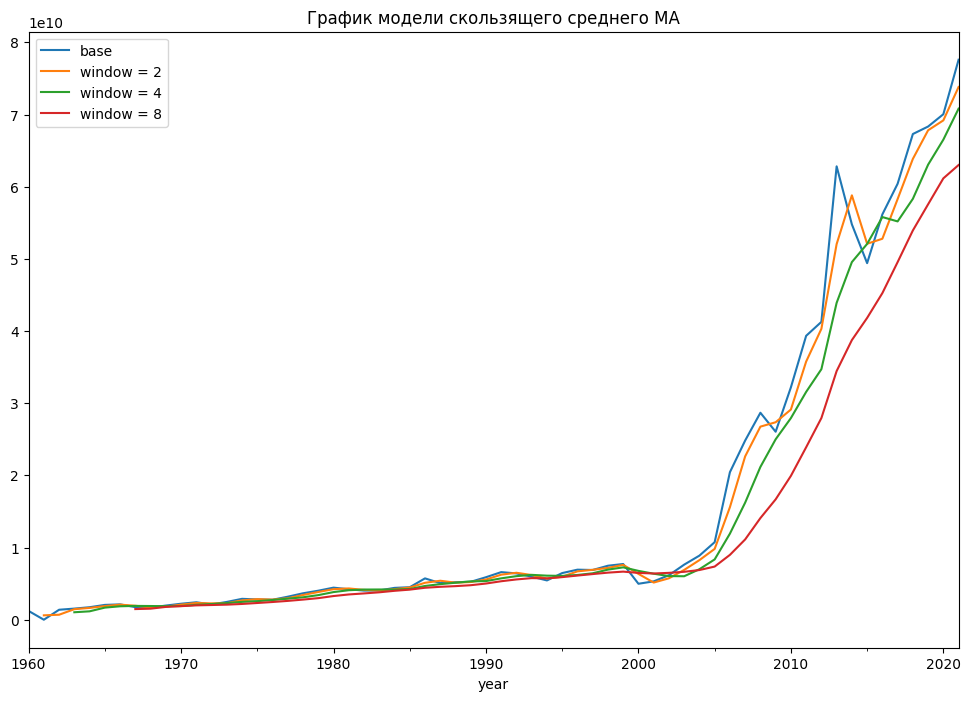

In [93]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
df.plot(ax=ax)
df.gdp.rolling(window=2).mean().plot(ax=ax)
df.gdp.rolling(window=4).mean().plot(ax=ax)
df.gdp.rolling(window=8).mean().plot(ax=ax)
ax.legend(['base', 'window = 2', 'window = 4', 'window = 8'])
ax.set_title('График модели скользящего среднего MA')
plt.show()

**Выводы:** график скользящего среднего обычно используется для выявления и визуализации тренда. В нашем случае и распределение основного признака без преобразований отлично показывает тренд. Но график скользящего среднего с окном в 4-8 вполне дополняет наши первоначальные выводы.
Хотя окно более 4 уже скрывает просадки во время мировых финансовых кризисов. Поэтому в данном случае лучше использовать усреднение с окном не более 2.

## 3. Построение модели ARMA/ARIMA

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели `ARMA/ARIMA`.

> **Примечание:** Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры `p` и `q` выберите по коррелограммам `ACF` и `PACF`.

> **Примечание**: Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель `ARMA/ARIMA` для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент `AIC` (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

Для начала определим функцию, которая позволит нам узнать, является ли ряд стационарным.

In [94]:
def stat_test(df):
    """Определить, является ли входящий временной ряд стационарным

    Args:
        df (DataFrame): Dataframe с временным рядом на проверку стационарности тестом Дики-Фуллера
    """
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

Проверим наш ряд:

In [95]:
stat_test(train_df)

adf:  0.6529066974885374
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Ряд не является стационарным, необходимо его продифференцировать.

adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


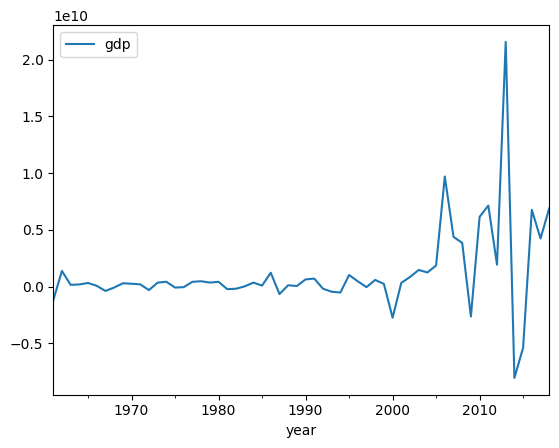

In [96]:
train_df_diff_1 = train_df.diff().dropna()
train_df_diff_1.plot()
stat_test(train_df_diff_1)

Ряд не стационарен, продолжаем дифферинцировать, пока не добьёмся стационарности:

adf:  -2.640869056128484
p-value:  0.08484116917837775
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


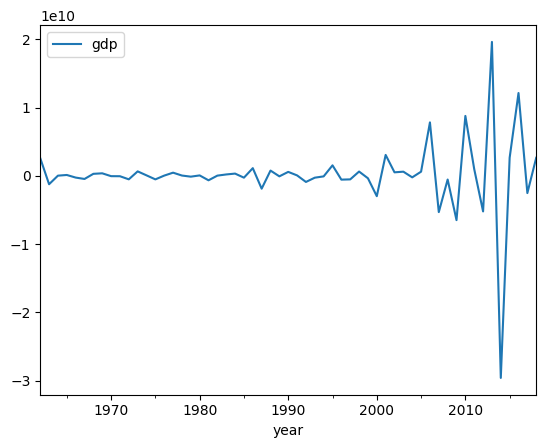

In [97]:
train_df_diff_2 = train_df_diff_1.diff().dropna()
train_df_diff_2.plot()
stat_test(train_df_diff_2)

adf:  -4.779623784828535
p-value:  5.9483276402248264e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
единичных корней нет, ряд стационарен


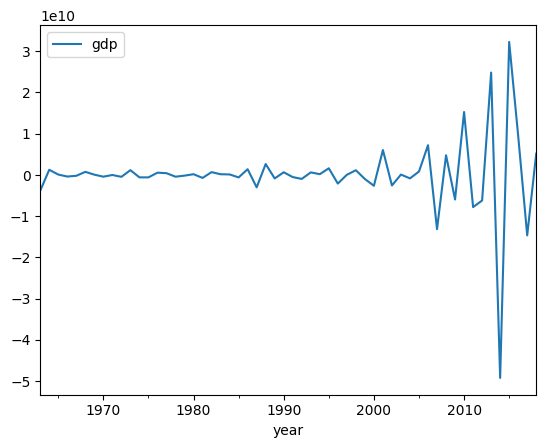

In [98]:
train_df_diff_3 = train_df_diff_2.diff().dropna()
train_df_diff_3.plot()
stat_test(train_df_diff_3)

**Вывод:** на третье дифференцирование ряд стал стационарным, то есть мы убрали из ряда тренд.

> **Примечение:** если бы порядок дифференцирования был выше, то вместо последовательных вызовов можно было бы написать функцию, которая в цикле или в рекурсии дифференцирует ряды, пока ряд не станет стационарным. Но для 3 порядка можно не тратить на это силы.

In [100]:
# запоминаем порядок дифференциала
d = 3